In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF

from utils.data_util import parse_bj_aq_data
from utils.plot_util import plot_forecast_and_actual_example
from metrics.metrics import SMAPE_on_dataset
from seq2seq.seq2seq_data_util import generate_train_samples, generate_test_samples
from seq2seq.multi_variable_seq2seq_model import build_graph

%load_ext autoreload
%autoreload 2

/home/cvdev/tf/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

gpu_config = tf.ConfigProto()
gpu_config.gpu_options.allow_growth = True
session = tf.Session(config=gpu_config)
KTF.set_session(session)

## Data exploration

In [4]:
bj_aq_data, stations, bj_aq_stations, bj_aq_stations_merged = parse_bj_aq_data()

NaN in PM2.5 is 23459, 6.508615 %
NaN in PM10 is 96175, 26.683406 %
NaN in NO2 is 21720, 6.026135 %
NaN in CO is 46144, 12.802486 %
NaN in O3 is 23732, 6.584358 %
NaN in SO2 is 21664, 6.010598 %
There are 35 air quality stations in Beijing

The stations in Beijing are:
 {'yungang_aq', 'miyun_aq', 'dongsihuan_aq', 'liulihe_aq', 'miyunshuiku_aq', 'nansanhuan_aq', 'tongzhou_aq', 'badaling_aq', 'dongsi_aq', 'daxing_aq', 'zhiwuyuan_aq', 'wanliu_aq', 'xizhimenbei_aq', 'yufa_aq', 'yongdingmennei_aq', 'donggaocun_aq', 'tiantan_aq', 'mentougou_aq', 'yanqin_aq', 'yizhuang_aq', 'pinggu_aq', 'dingling_aq', 'fangshan_aq', 'shunyi_aq', 'yongledian_aq', 'guanyuan_aq', 'fengtaihuayuan_aq', 'pingchang_aq', 'nongzhanguan_aq', 'wanshouxigong_aq', 'aotizhongxin_aq', 'qianmen_aq', 'gucheng_aq', 'huairou_aq', 'beibuxinqu_aq'}


/home/cvdev/air-quality-prediction/utils/data_util.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  bj_aq_station.drop("utc_time", axis=1, inplace=True)
/home/cvdev/air-quality-prediction/utils/data_util.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  bj_aq_station.drop("stationId", axis=1, inplace=True)


### Use part of data(3 stations, version 1) or all data(35 stations, version 2)

In [12]:
# Version 1 : use 3 stations
all_features = bj_aq_stations_merged.dtypes.index
features = [i for i in all_features if 'yizhuang' in i or 'gucheng' in i or 'nongzhanguan' in i]

# use all selected features for input
input_features = features
# just use pm2.5, pm15 and O3 for output
output_features = [i for i in features if "PM2.5" in i or "PM10" in i or "O3" in i]

print("There are %d features in the input and %d features in the output." %(len(input_features), len(output_features)))

There are 18 features in the input and 9 features in the output.


In [5]:
# Version 2 : use all 210 features
all_features = bj_aq_stations_merged.dtypes.index
features = all_features

# use all selected features for input
input_features = features
# just use pm2.5, pm15 and O3 for output
output_features = [i for i in features if "PM2.5" in i or "PM10" in i or "O3" in i]

print("There are %d features in the input and %d features in the output." %(len(input_features), len(output_features)))

There are 210 features in the input and 105 features in the output.


In [6]:
df = bj_aq_stations_merged[features]
df = df.reset_index()
df = df.drop(columns=["format_time"])

In [7]:
# 缺失值处理，缺失值处理当前尽在 .ipynb 中生效，在 .py 文件中不生效
df.fillna(0, inplace=True)
# df.fillna(method="ffill", inplace=True)
df.isnull().values.any()

False

In [8]:
df.head()

,donggaocun_aq_PM2.5,donggaocun_aq_PM10,donggaocun_aq_NO2,donggaocun_aq_CO,donggaocun_aq_O3,donggaocun_aq_SO2,gucheng_aq_PM2.5,gucheng_aq_PM10,gucheng_aq_NO2,gucheng_aq_CO,...,liulihe_aq_NO2,liulihe_aq_CO,liulihe_aq_O3,liulihe_aq_SO2,yongdingmennei_aq_PM2.5,yongdingmennei_aq_PM10,yongdingmennei_aq_NO2,yongdingmennei_aq_CO,yongdingmennei_aq_O3,yongdingmennei_aq_SO2
0,377.0,0.0,123.0,5.5,2.0,6.0,500.0,612.0,161.0,7.7,...,116.0,5.5,2.0,16.0,415.0,0.0,143.0,6.7,12.0,12.0
1,387.0,0.0,123.0,5.3,2.0,5.0,490.0,594.0,150.0,7.9,...,133.0,5.6,2.0,17.0,409.0,0.0,143.0,0.7,12.0,13.0
2,351.0,0.0,126.0,4.6,2.0,5.0,513.0,618.0,157.0,8.7,...,134.0,5.7,2.0,18.0,401.0,0.0,134.0,7.1,12.0,11.0
3,274.0,0.0,122.0,3.7,2.0,5.0,528.0,609.0,170.0,9.9,...,137.0,5.9,2.0,17.0,407.0,0.0,126.0,7.2,12.0,10.0
4,200.0,0.0,101.0,2.8,2.0,5.0,297.0,609.0,92.0,4.4,...,137.0,6.2,2.0,16.0,415.0,0.0,142.0,7.3,13.0,12.0


## Preprocessing

In [9]:
## Split into train and test - I used the last 1 month data as test, but it's up to you to decide the ratio
df_train = df.iloc[:(-31*24), :].copy()
df_test = df.iloc[-31*24:, :].copy()

## take out the useful columns for modeling
X_train = df_train.loc[:, input_features].values.copy()
X_test = df_test.loc[:, input_features].values.copy()

y_train = df_train[output_features].values.copy()
y_test = df_test[output_features].values.copy()

In [10]:
print("number of training data to be used, features")
print(X_train.shape, y_train.shape)
print("number of testing data to be used, features")
print(X_test.shape, y_test.shape)

number of training data to be used, features
(9554, 210) (9554, 105)
number of testing data to be used, features
(744, 210) (744, 105)


In [11]:
## z-score transform x
for i in range(X_train.shape[1]):
    temp_mean = X_train[:, i].mean()
    temp_std = X_train[:, i].std()
    X_train[:, i] = (X_train[:, i] - temp_mean) / temp_std
    X_test[:, i] = (X_test[:, i] - temp_mean) / temp_std
    
## z-score transform y
y_mean = y_train.mean()
y_std = y_train.std()
y_train = (y_train - y_mean) / y_std
y_test = (y_test - y_mean) / y_std

In [12]:
print("the mean and std of y are : ", y_mean, y_std)

the mean and std of y are :  68.2575116879492 74.197254197169


## Prepare training and test datasets in 3-D format - (batch_size, time_step, feature_dim)

In [13]:
# define parameters here
batch_size = 32
input_seq_len = 120
output_seq_len = 48

In [16]:
len(X_train)

9554

In [12]:
x, y = generate_train_samples(x=X_train, y=y_train, batch_size=batch_size, input_seq_len=input_seq_len, output_seq_len=output_seq_len)
print("batch_size, input/output_seq_length, features")
print(x.shape, y.shape)

batch_size, input/output_seq_length, features
(32, 120, 210) (32, 48, 105)


In [13]:
test_x, test_y = generate_test_samples(X_test, y_test, input_seq_len, output_seq_len)
print(test_x.shape, test_y.shape)

(576, 120, 210) (576, 48, 105)


## Building the model and train the model 

In [15]:
total_iteractions = 200
batch_size = 256
KEEP_RATE = 0.5
train_losses = []
val_losses = []

rnn_model = build_graph(feed_previous=False)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    losses = []
    print("Training losses: ")
    for i in range(total_iteractions):
        batch_input, batch_output = generate_train_samples(x=X_train, y=y_train, batch_size=batch_size, input_seq_len=input_seq_len, output_seq_len=output_seq_len)
        
        feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t] for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t] for t in range(output_seq_len)})
        _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
        if i%10 == 0:
            print("loss after %d/%d iteractions : %.3f" %(i, total_iteractions, loss_t))
        losses.append(loss_t)
        
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, os.path.join('./seq2seq/multi_variable_model_results/', 'multivariate_ts_pollution_case'))
        
print("Checkpoint saved at: ", save_path)


Training losses: 
loss after 0/200 iteractions : 163.801
loss after 10/200 iteractions : 92.222
loss after 20/200 iteractions : 85.275
loss after 30/200 iteractions : 78.803
loss after 40/200 iteractions : 75.917
loss after 50/200 iteractions : 74.326
loss after 60/200 iteractions : 72.060
loss after 70/200 iteractions : 71.524
loss after 80/200 iteractions : 69.162
loss after 90/200 iteractions : 70.426
loss after 100/200 iteractions : 68.970
loss after 110/200 iteractions : 67.437
loss after 120/200 iteractions : 67.107
loss after 130/200 iteractions : 68.001
loss after 140/200 iteractions : 66.830
loss after 150/200 iteractions : 67.541
loss after 160/200 iteractions : 66.327
loss after 170/200 iteractions : 66.452
loss after 180/200 iteractions : 65.620
loss after 190/200 iteractions : 66.240
Checkpoint saved at:  ./seq2seq/multi_variable_model_results/multivariate_ts_pollution_case


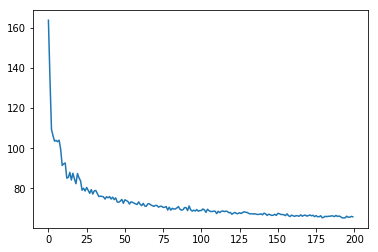

In [16]:
%matplotlib inline
plt.plot(losses)

## Inference on test 
Notice the batch prediction which is different to previous

In [17]:
# length of input signals
input_seq_len = 120
# length of output signals
output_seq_len = 48
# num of input signals
input_dim = 210
# num of output signals
output_dim = 105

In [18]:
rnn_model = build_graph(feed_previous=True)

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    saver = rnn_model['saver']().restore(sess,  os.path.join('./seq2seq/multi_variable_model_results/', 'multivariate_ts_pollution_case'))
    
    feed_dict = {rnn_model['enc_inp'][t]: test_x[:, t, :] for t in range(input_seq_len)} # batch prediction
    feed_dict.update({rnn_model['target_seq'][t]: np.zeros([test_x.shape[0], output_dim], dtype=np.float32) for t in range(output_seq_len)})
    final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
    
    final_preds = [np.expand_dims(pred, 1) for pred in final_preds]
    final_preds = np.concatenate(final_preds, axis = 1)
    print("Test mse is: ", np.mean((final_preds - test_y)**2))

INFO:tensorflow:Restoring parameters from ./seq2seq/multi_variable_model_results/multivariate_ts_pollution_case
Test mse is:  3.214855129780255


In [25]:
print("Shape of predictions is ",final_preds.shape)

Shape of predictions is  (576, 48, 105)


### Example of many featutres

In [26]:
print(output_features)

['nansanhuan_aq_PM2.5', 'nansanhuan_aq_PM10', 'nansanhuan_aq_O3', 'yungang_aq_PM2.5', 'yungang_aq_PM10', 'yungang_aq_O3', 'miyun_aq_PM2.5', 'miyun_aq_PM10', 'miyun_aq_O3', 'donggaocun_aq_PM2.5', 'donggaocun_aq_PM10', 'donggaocun_aq_O3', 'tongzhou_aq_PM2.5', 'tongzhou_aq_PM10', 'tongzhou_aq_O3', 'guanyuan_aq_PM2.5', 'guanyuan_aq_PM10', 'guanyuan_aq_O3', 'fangshan_aq_PM2.5', 'fangshan_aq_PM10', 'fangshan_aq_O3', 'yanqin_aq_PM2.5', 'yanqin_aq_PM10', 'yanqin_aq_O3', 'xizhimenbei_aq_PM2.5', 'xizhimenbei_aq_PM10', 'xizhimenbei_aq_O3', 'beibuxinqu_aq_PM2.5', 'beibuxinqu_aq_PM10', 'beibuxinqu_aq_O3', 'dongsihuan_aq_PM2.5', 'dongsihuan_aq_PM10', 'dongsihuan_aq_O3', 'yufa_aq_PM2.5', 'yufa_aq_PM10', 'yufa_aq_O3', 'daxing_aq_PM2.5', 'daxing_aq_PM10', 'daxing_aq_O3', 'huairou_aq_PM2.5', 'huairou_aq_PM10', 'huairou_aq_O3', 'zhiwuyuan_aq_PM2.5', 'zhiwuyuan_aq_PM10', 'zhiwuyuan_aq_O3', 'yongledian_aq_PM2.5', 'yongledian_aq_PM10', 'yongledian_aq_O3', 'shunyi_aq_PM2.5', 'shunyi_aq_PM10', 'shunyi_aq_O3',

/home/cvdev/tf/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


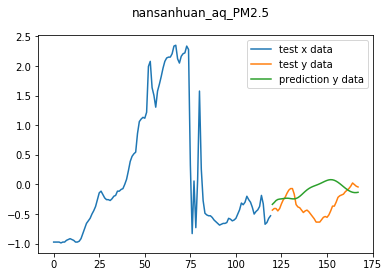

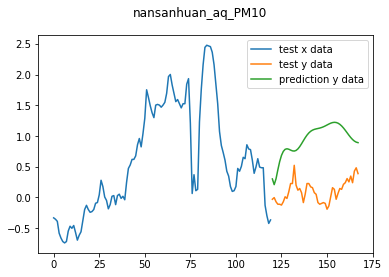

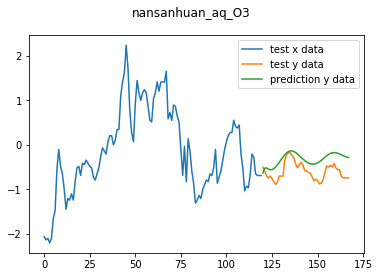

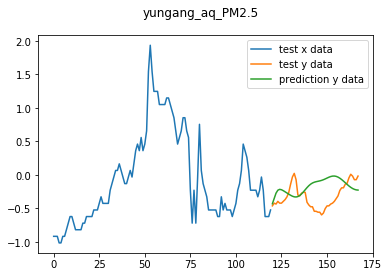

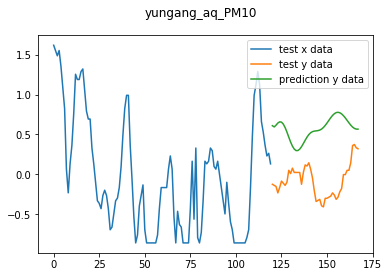

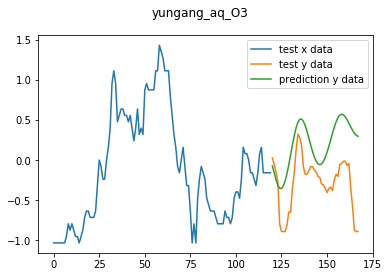

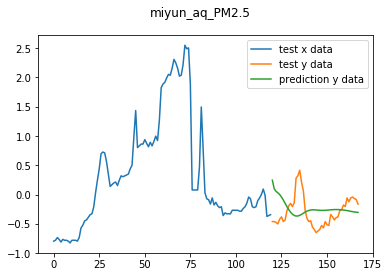

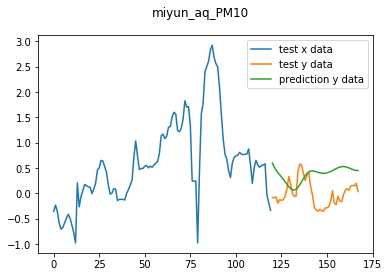

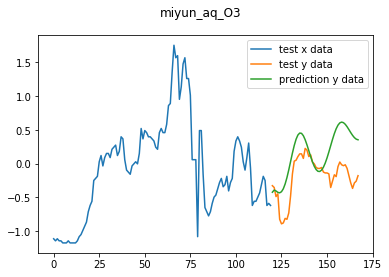

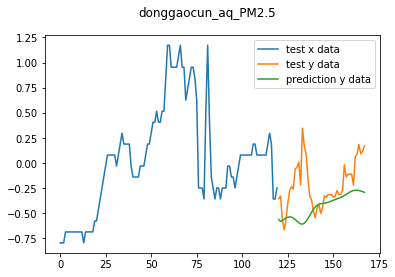

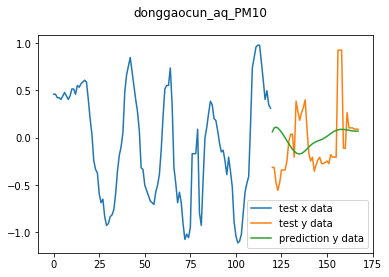

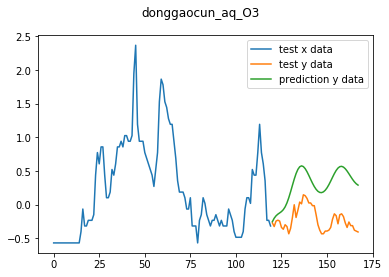

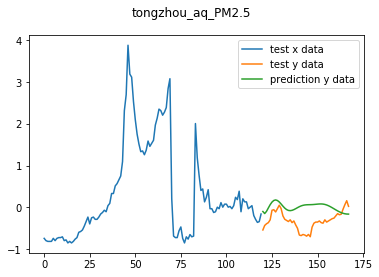

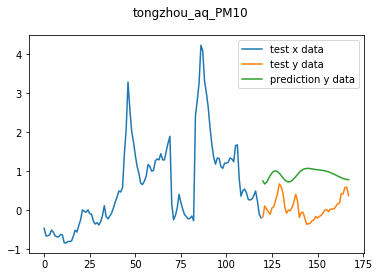

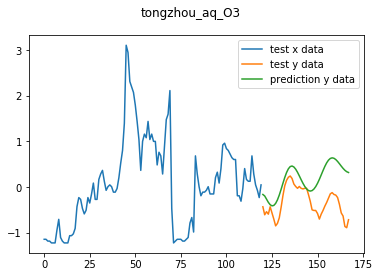

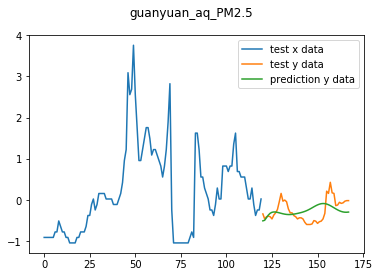

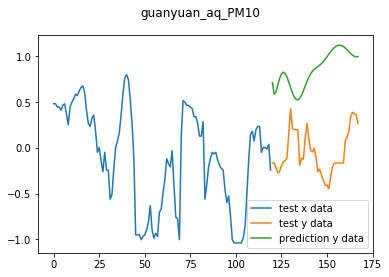

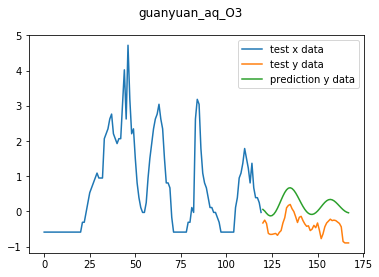

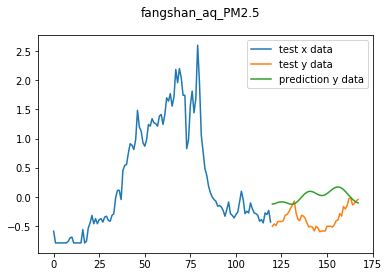

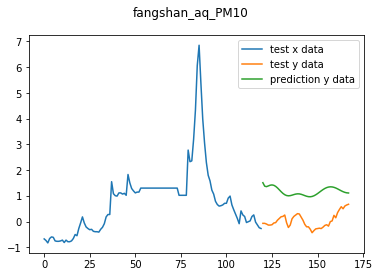

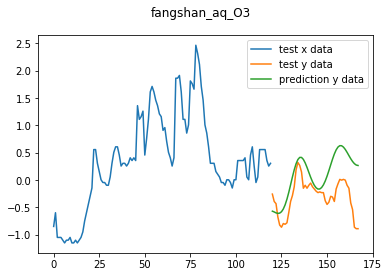

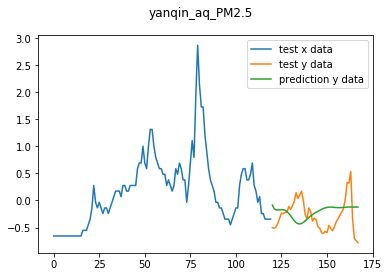

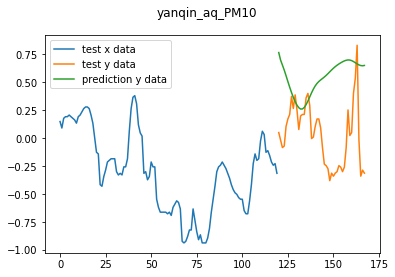

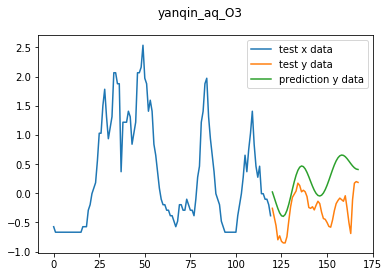

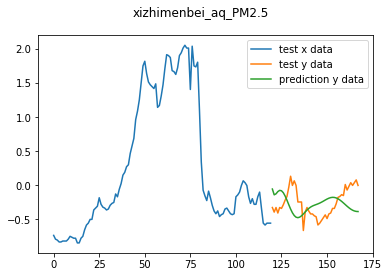

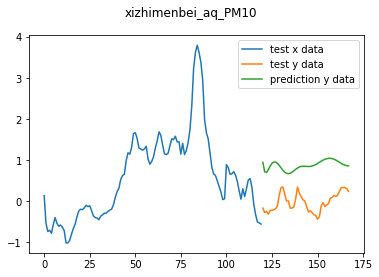

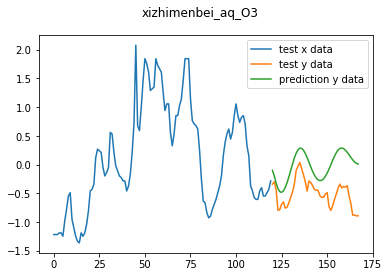

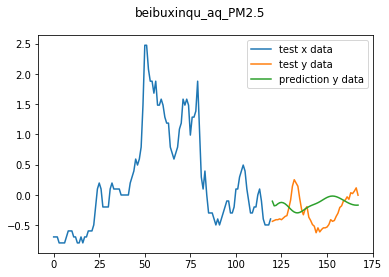

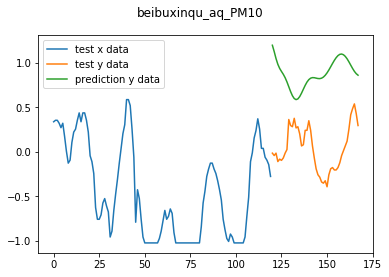

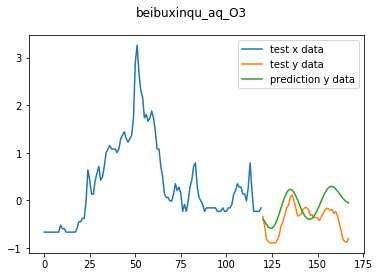

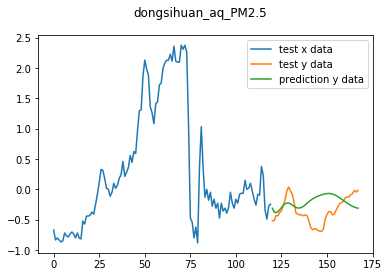

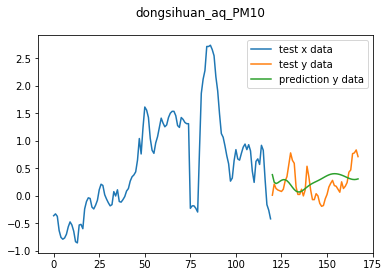

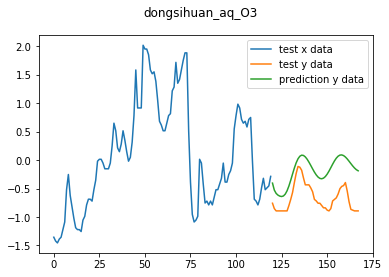

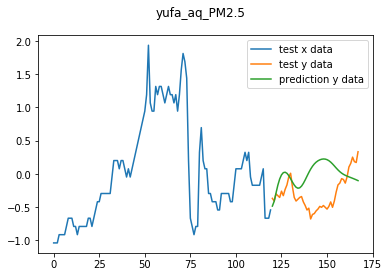

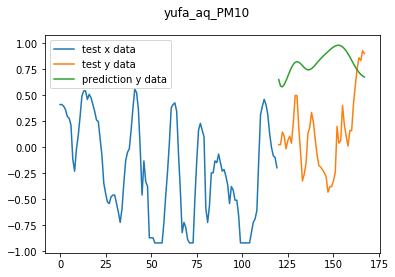

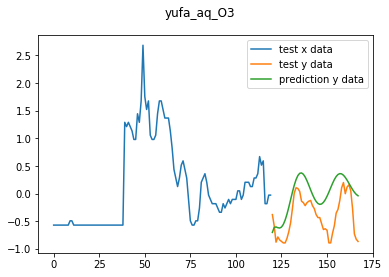

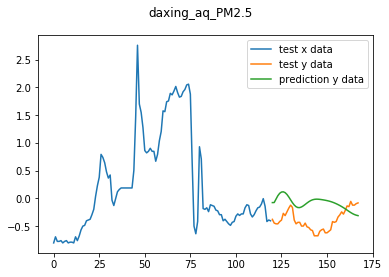

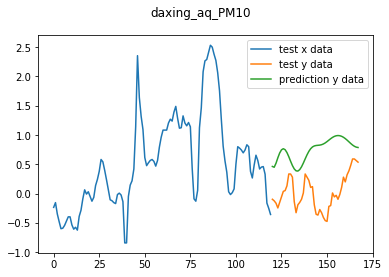

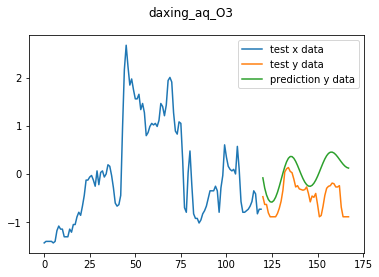

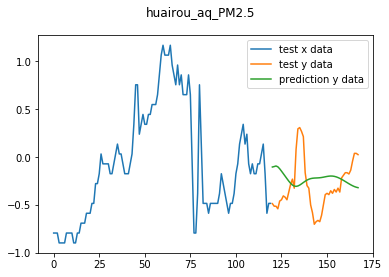

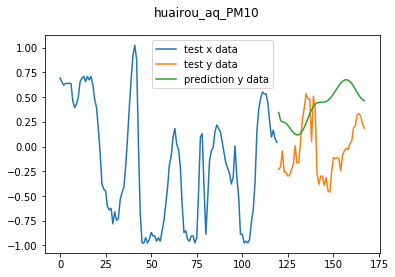

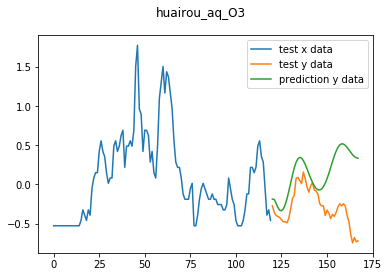

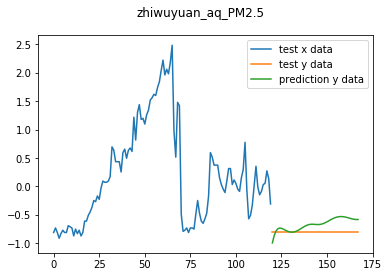

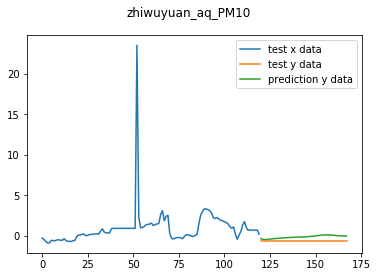

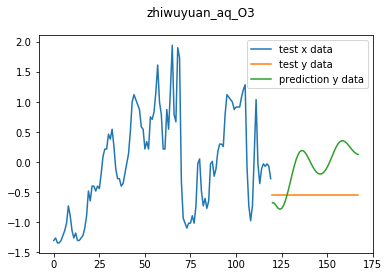

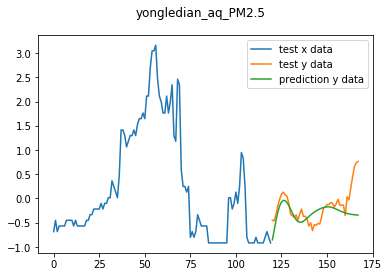

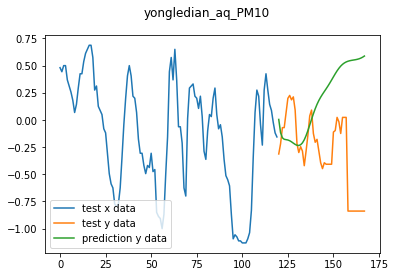

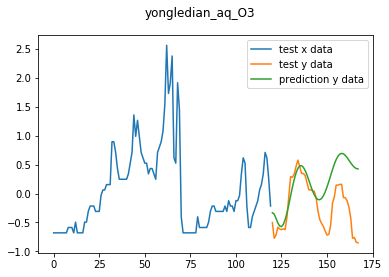

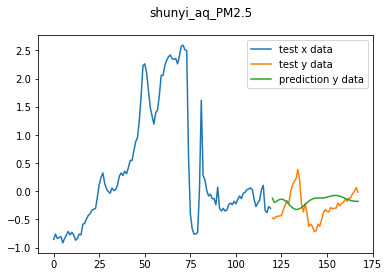

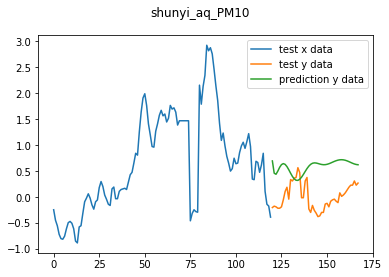

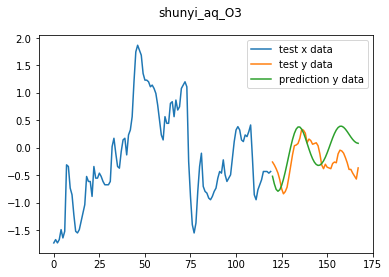

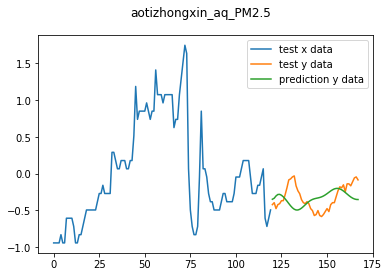

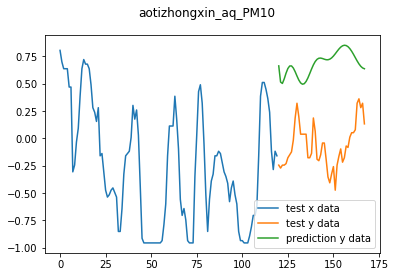

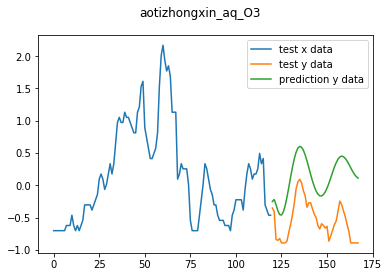

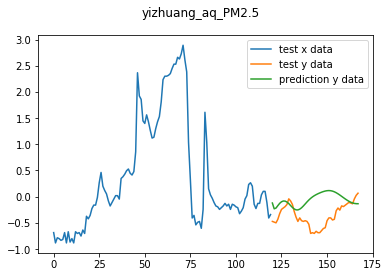

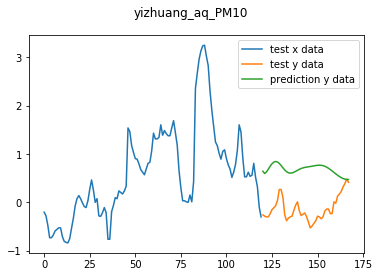

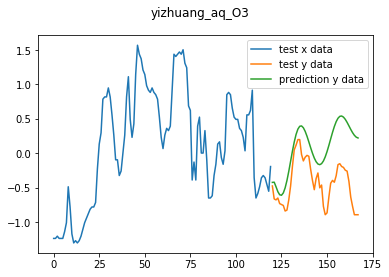

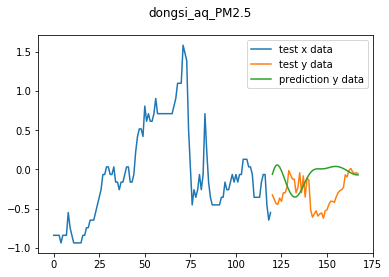

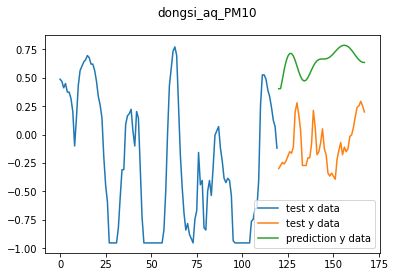

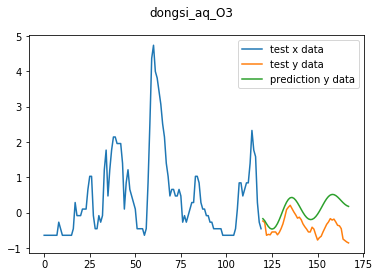

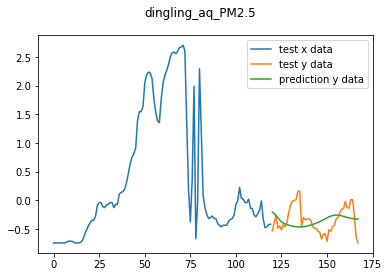

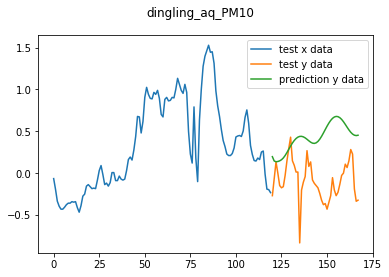

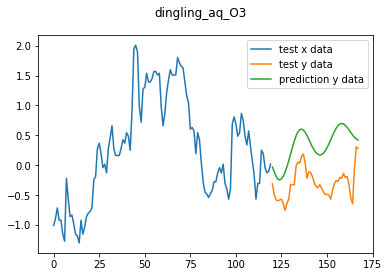

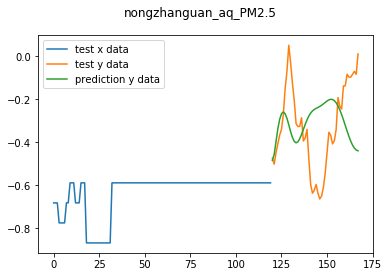

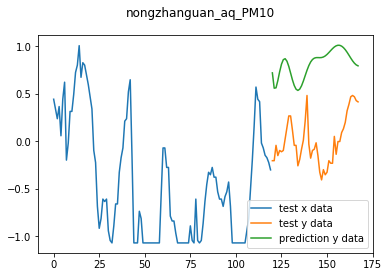

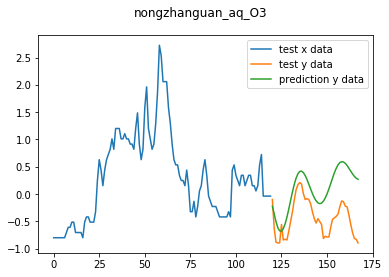

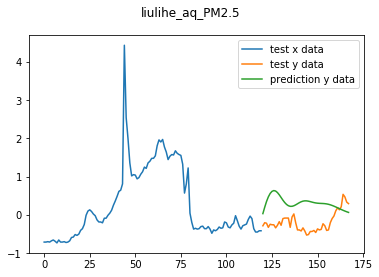

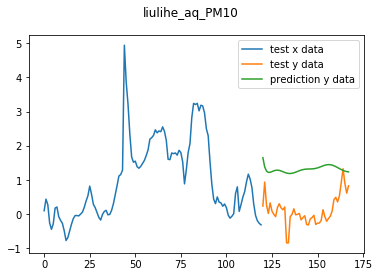

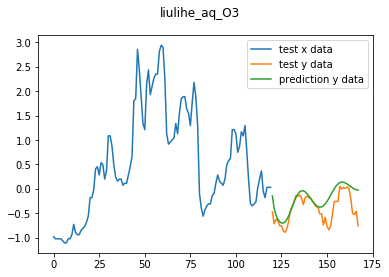

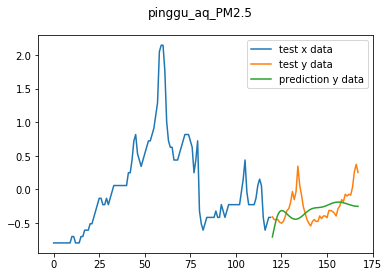

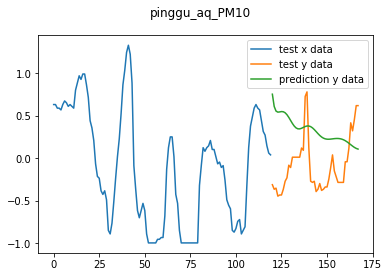

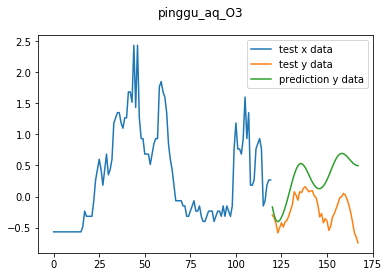

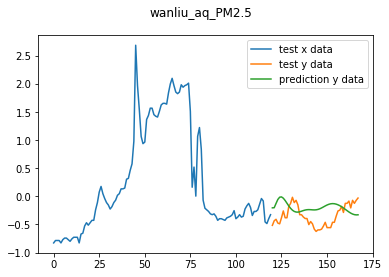

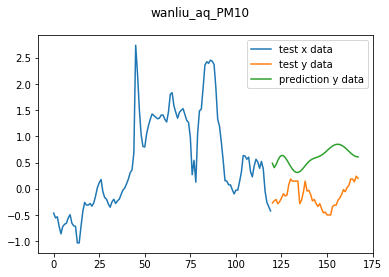

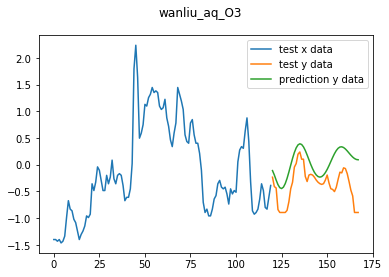

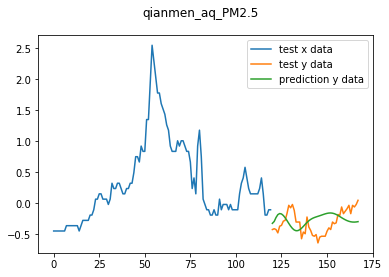

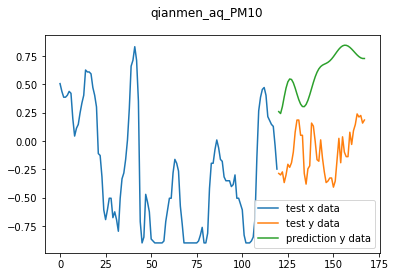

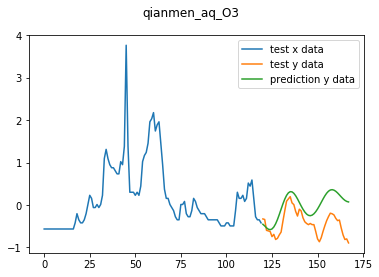

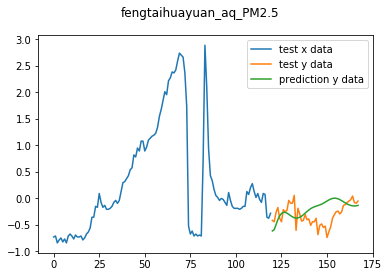

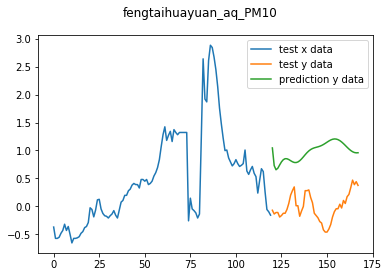

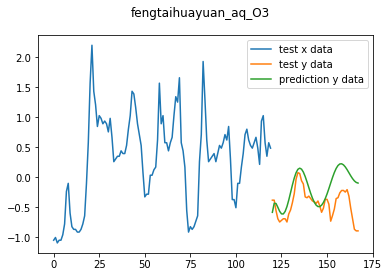

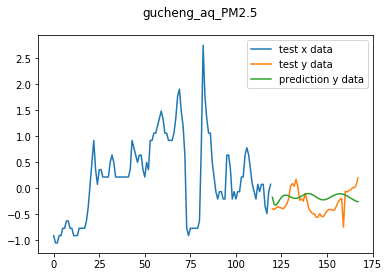

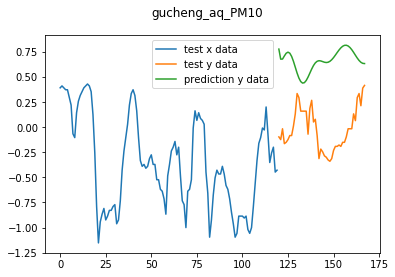

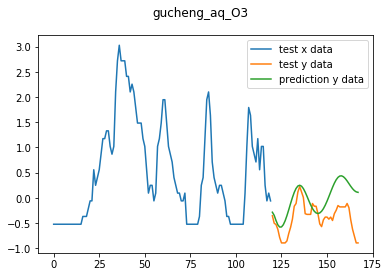

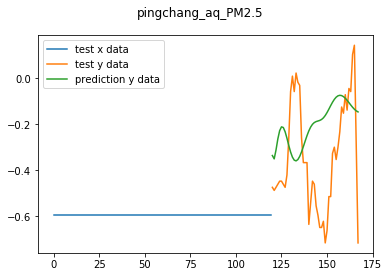

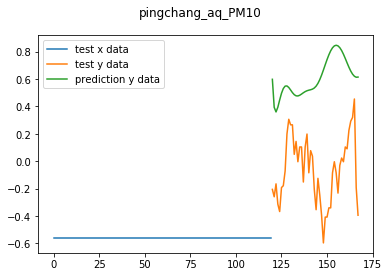

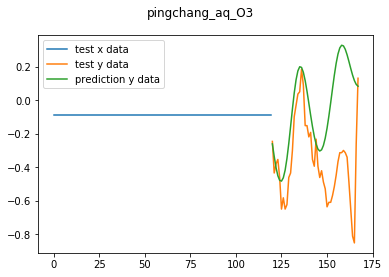

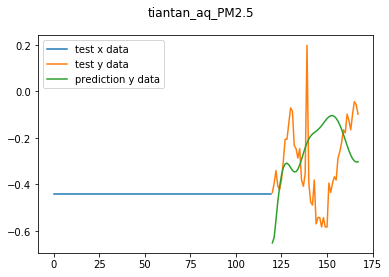

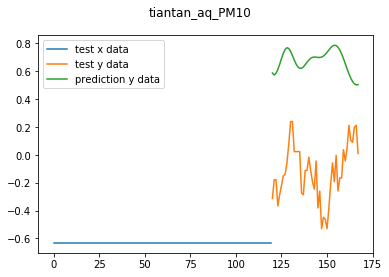

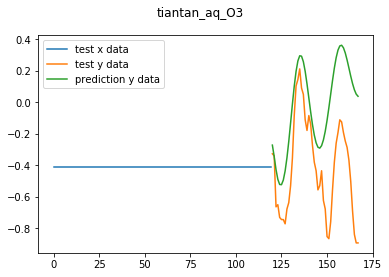

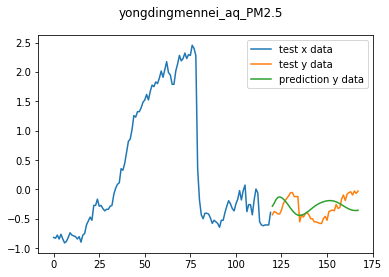

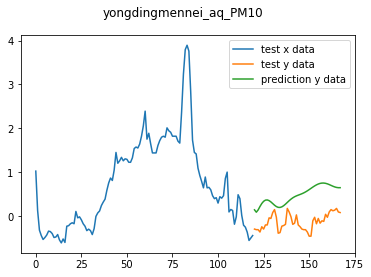

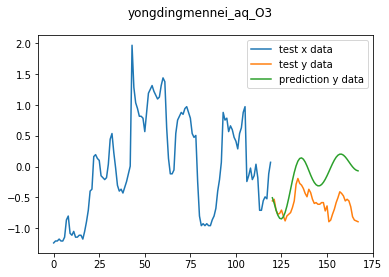

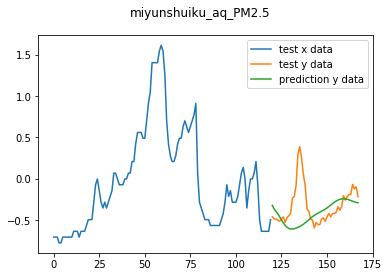

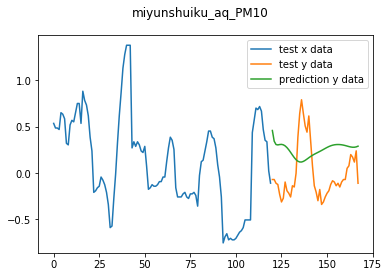

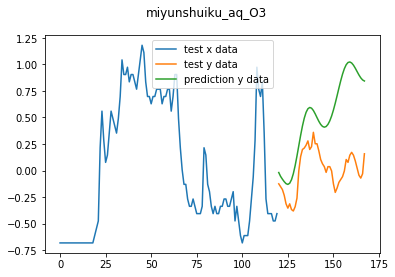

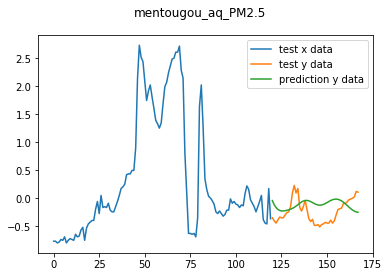

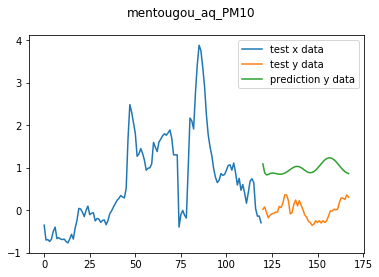

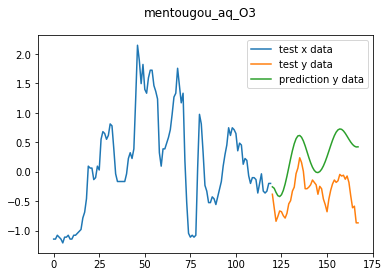

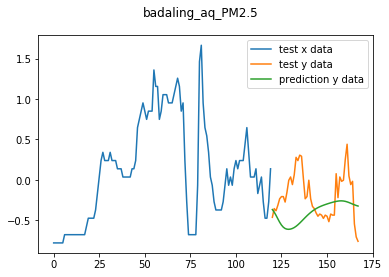

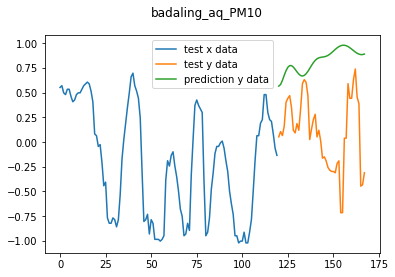

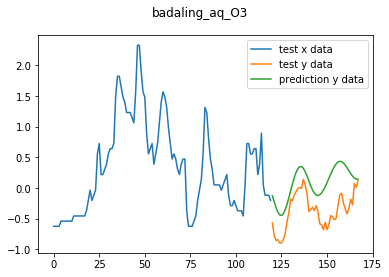

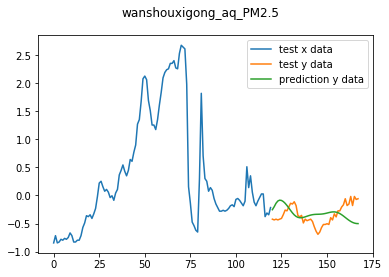

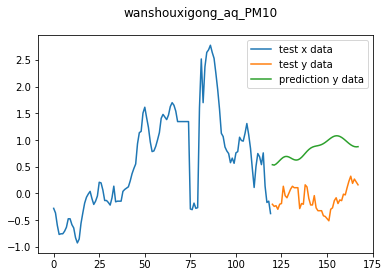

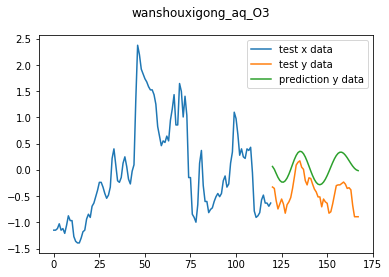

In [27]:
# 预测值普遍在 O3 上表现较好，另外两个参数　PM2.5 和　PM10 上通常捕捉不到高频分量
for i in range(len(output_features)):
    plot_forecast_and_actual_example(test_x, test_y, final_preds, output_features, index=0, feature_index=i)

### 某个特征在整个dev数据集时间跨度上的表现

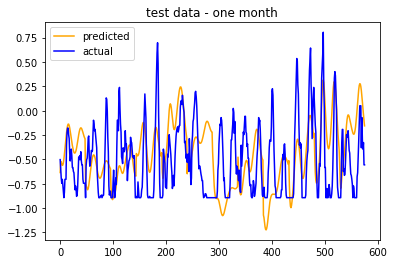

In [21]:
## remove duplicate hours and concatenate into one long array
feature_index = 2
test_y_expand = np.concatenate([test_y[i,:,feature_index] for i in range(0, test_y.shape[0], output_seq_len)], axis = 0)
final_preds_expand = np.concatenate([final_preds[i,:,feature_index] for i in range(0, final_preds.shape[0], output_seq_len)], axis = 0)
plt.plot(final_preds_expand, color = 'orange', label = 'predicted')
plt.plot(test_y_expand, color = 'blue', label = 'actual')
plt.title("test data - one month")
plt.legend(loc="upper left")
plt.show()

### Smapes of all features

In [38]:
aver_smapes, smapes_of_features = SMAPE_on_dataset(test_y, final_preds, output_features, y_mean, y_std, 24)

In [39]:
# smape value on all features
smapes_of_features

{'aotizhongxin_aq_O3': 0.9649275193205699,
 'aotizhongxin_aq_PM10': 0.6078576343019357,
 'aotizhongxin_aq_PM2.5': 0.6409291507543996,
 'badaling_aq_O3': 0.8283348350538485,
 'badaling_aq_PM10': 0.5238095472879004,
 'badaling_aq_PM2.5': 0.6518094072600796,
 'beibuxinqu_aq_O3': 1.1008016726229206,
 'beibuxinqu_aq_PM10': 0.5966188749727666,
 'beibuxinqu_aq_PM2.5': 0.6478818144344237,
 'daxing_aq_O3': 0.9909637616413237,
 'daxing_aq_PM10': 0.584060481344378,
 'daxing_aq_PM2.5': 0.6737934501528464,
 'dingling_aq_O3': 0.5936755994843467,
 'dingling_aq_PM10': 0.6038229213298166,
 'dingling_aq_PM2.5': 0.6560723787889088,
 'donggaocun_aq_O3': 0.6216981737977799,
 'donggaocun_aq_PM10': 0.5427336401980901,
 'donggaocun_aq_PM2.5': 0.6556073291116321,
 'dongsi_aq_O3': 0.834776128793249,
 'dongsi_aq_PM10': 0.6220416568424839,
 'dongsi_aq_PM2.5': 0.6429326210886722,
 'dongsihuan_aq_O3': 1.0591137939006288,
 'dongsihuan_aq_PM10': 0.7368646640663755,
 'dongsihuan_aq_PM2.5': 0.7118833716895984,
 'fangsh

In [42]:
print("The average smape on all features in the dev set is : ",aver_smapes)

The average smape on all features in the dev set is :  0.7089477122267855


# ChangeLog
- 0419 
    - 修正了 SMAPE 计算方法，将 正则化的因素考虑进去
    - 整理了多变量 seq2seq 模型，验证集上 SMAPE 为 0.709  